In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from sklearn.linear_model import LinearRegression, Ridge, Lasso

%matplotlib inline

In [2]:
yr_to_sec = 3600.0*24.0*365.25
km_to_kpc = 3.086e16
rad_to_mas = 1.0e3*3600.0/np.pi*180.0

In [3]:
# data = np.load('DR2_stars.npy')
data_anticenter = np.load('DR2_MW_anticenter.npy')
data_center = np.load('DR2_MW_center.npy')


print(data_anticenter.shape)
print(data_anticenter.dtype)

print(data_center.shape)
print(data_center.dtype)

(17107,)
[('pmra', '<f8'), ('pmdec', '<f8'), ('parallax', '<f8'), ('parallax_error', '<f8')]
(62560,)
[('pmra', '<f8'), ('pmdec', '<f8'), ('parallax', '<f8'), ('parallax_error', '<f8')]


### Let's look at the data

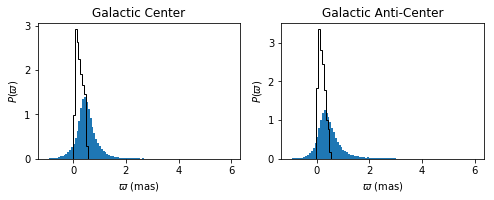

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8,2.5))

bins = np.linspace(-1, 6, 100)

ax[0].hist(data_center['parallax'], bins=bins, normed=True)
ax[0].hist(data_center['parallax_error'], bins=bins, normed=True, histtype='step', color='k')


ax[1].hist(data_anticenter['parallax'], bins=bins, normed=True)
ax[1].hist(data_anticenter['parallax_error'], bins=bins, normed=True, histtype='step', color='k')

ax[0].set_title('Galactic Center')
ax[1].set_title('Galactic Anti-Center')

for a in ax:
    a.set_xlabel(r'$\varpi$ (mas)')
    a.set_ylabel(r'$P(\varpi)$')
plt.show()

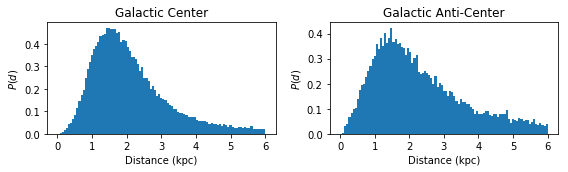

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8,2.5))


bins = np.linspace(0, 6.0, 100)

dist_center = 1.0/data_center['parallax']
ax[0].hist(dist_center, bins=bins, normed=True)

dist_anticenter = 1.0/data_anticenter['parallax']
ax[1].hist(dist_anticenter, bins=bins, normed=True)


for a in ax:
    a.set_xlabel(r'Distance (kpc)')
    a.set_ylabel(r'$P(d)$')

ax[0].set_title('Galactic Center')
ax[1].set_title('Galactic Anti-Center')


plt.tight_layout()
plt.show()

### Select only stars with "good" parallaxes

In [6]:
idx = np.where(data_center['parallax']/data_center['parallax_error'] > 5.0)[0]
dist_center = dist_center[idx]
data_center = data_center[idx]

idx = np.where(data_anticenter['parallax']/data_anticenter['parallax_error'] > 5.0)[0]
dist_anticenter = dist_anticenter[idx]
data_anticenter = data_anticenter[idx]

print(data_center.shape)
print(data_anticenter.shape)

(13359,)
(4426,)


### Calculate Galactic UVW velocities

In [7]:
ra_MW_center, dec_MW_center = 266.6, -28.9
ra_MW_anticenter, dec_MW_anticenter = 86.6, 28.9

def calc_UVW(ra, dec, dist, mu_ra, mu_dec, v_r, degree=True):

    # Adjust for local standard of rest
    # According to Appendix A of Bensby et al. (2003)
    
    if degree == True:
        ra = ra * np.pi/180.0
        dec = dec * np.pi/180.0
        
    # Make arrays if only float inputs
    if not isinstance(ra, np.ndarray):
        ra = np.array([ra])
        dec = np.array([dec])
        dist = np.array([dist])
        mu_ra = np.array([mu_ra])
        mu_dec = np.array([mu_dec])
        v_r = np.array([v_r])
        
    G = np.array([[-0.0548756, -0.8734371, -0.4838350],
                  [0.4941094, -0.4448296, 0.7469822],
                  [-0.8676661, -0.1980764, 0.4559838]])
        
    R = np.zeros(shape=(3,3,len(dist)))
    for i in range(len(ra)):
        R[:,:,i] = np.array([[-np.sin(ra[i]), -np.cos(ra[i])*np.sin(dec[i]), np.cos(ra[i])*np.cos(dec[i])],
                            [np.cos(ra[i]), -np.sin(ra[i])*np.sin(dec[i]), np.sin(ra[i])*np.cos(dec[i])],
                            [0.0, np.cos(dec[i]), np.sin(dec[i])]])
    
    C = 4.74047
    X = np.array([C * dist * mu_ra, C * dist * mu_dec, v_r])

    UVW = np.zeros(shape=((3, len(ra))))
#     UVW_solar = np.array([10.0, 5.25, 7.17])
            
    for i in range(len(dist)):
    
        UVW[:,i] = np.dot(G, np.dot(R[:,:,i],X[:,i]))
#         UVW[:,i] = UVW[:,i] + UVW_solar
        
    
    return UVW

In [8]:
ra_center = ra_MW_center*np.ones(len(data_center))
dec_center = dec_MW_center*np.ones(len(data_center))
rv_center = 0.0*np.ones(len(data_center))

UVW_center = calc_UVW(ra_center, dec_center, dist_center, 
                      data_center['pmra'], data_center['pmdec'], rv_center)
U_center = UVW_center[0]
V_center = UVW_center[1]
W_center = UVW_center[2]


ra_anticenter = ra_MW_anticenter*np.ones(len(data_anticenter))
dec_anticenter = dec_MW_anticenter*np.ones(len(data_anticenter))
rv_anticenter = 0.0*np.ones(len(data_anticenter))

UVW_anticenter = calc_UVW(ra_anticenter, dec_anticenter, dist_anticenter, 
                          data_anticenter['pmra'], data_anticenter['pmdec'], rv_anticenter)
U_anticenter = UVW_anticenter[0]
V_anticenter = UVW_anticenter[1]
W_anticenter = UVW_anticenter[2]

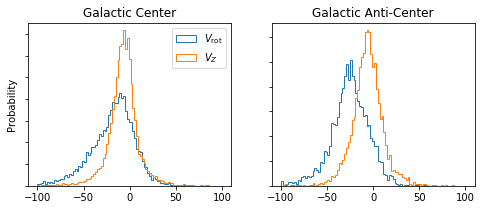

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))

bins = np.linspace(-100, 100, 100)
# plt.hist(UVW[0], histtype='step', bins=bins)
ax[0].hist(UVW_center[1], histtype='step', bins=bins, normed=True, label=r'$V_{\rm rot}$')
ax[0].hist(UVW_center[2], histtype='step', bins=bins, normed=True, label=r'$V_{Z}$')


ax[1].hist(UVW_anticenter[1], histtype='step', bins=bins, normed=True, label='Rotational Velocity')
ax[1].hist(UVW_anticenter[2], histtype='step', bins=bins, normed=True, label='Z Velocity')


ax[0].set_title('Galactic Center')
ax[1].set_title('Galactic Anti-Center')



ax[0].legend()

for a in ax:
    a.set_yticklabels([])


ax[0].set_ylabel('Probability')

plt.show()

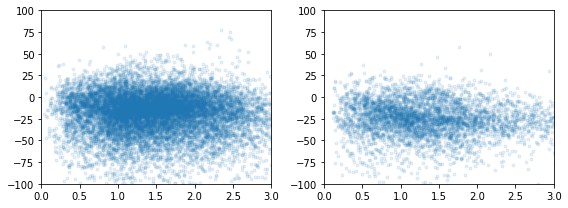

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].scatter(dist_center, V_center, marker='.', alpha=0.1)

ax[1].scatter(dist_anticenter, V_anticenter, marker='.', alpha=0.1)

for a in ax:
    a.set_xlim(0, 3)
    a.set_ylim(-100, 100)
    
plt.tight_layout()
plt.show()

In [11]:
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 4.0, 200)
widths = 0.1
X_center = gaussian_basis(dist_center[:, np.newaxis], centers, widths)
X_anticenter = gaussian_basis(dist_anticenter[:, np.newaxis], centers, widths)

/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


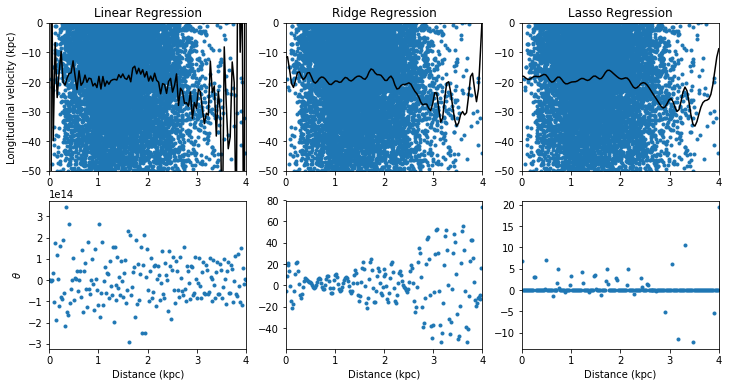

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.005), dict(alpha=0.001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']


X_grid = np.linspace(0, 4.0, 100)

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X_center, V_center)
    w_center = clf.coef_
    fit_center = clf.predict(gaussian_basis(X_grid[:, None], centers, widths))    

    
    ax[0,i].set_title(labels[i])

    ax[0,i].scatter(dist_center, V_center, marker='.')
    ax[0,i].plot(X_grid, fit_center, color='k', zorder=10)
    ax[0,i].set_xlim(0, 4)
    ax[0,i].set_ylim(-50, 0)
#     ax[0,i].set_xlabel('Distance (kpc)')
    
    ax[1,i].scatter(centers, w_center, marker='.')
    ax[1,i].set_xlim(0, 4)
    ax[1,i].set_xlabel('Distance (kpc)')
    
  
    if i == 0:
        ax[0,i].set_ylabel('Longitudinal velocity (kpc)')
        ax[1,i].set_ylabel(r'$\theta$')



plt.show()

/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


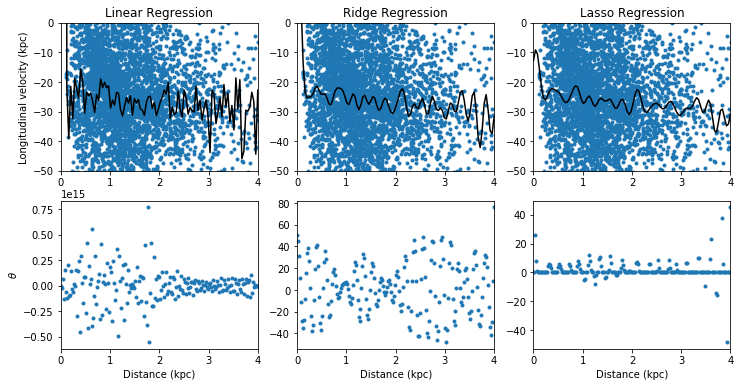

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.005), dict(alpha=0.001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']


X_grid = np.linspace(0, 4.0, 100)

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X_anticenter, V_anticenter)
    w_anticenter = clf.coef_
    fit_anticenter = clf.predict(gaussian_basis(X_grid[:, None], centers, widths))    

    
    ax[0,i].set_title(labels[i])

    ax[0,i].scatter(dist_anticenter, V_anticenter, marker='.')
    ax[0,i].plot(X_grid, fit_anticenter, color='k', zorder=10)
    ax[0,i].set_xlim(0, 4)
    ax[0,i].set_ylim(-50, 0)
#     ax[0,i].set_xlabel('Distance (kpc)')
    
    ax[1,i].scatter(centers, w_anticenter, marker='.')
    ax[1,i].set_xlim(0, 4)
    ax[1,i].set_xlabel('Distance (kpc)')
    
  
    if i == 0:
        ax[0,i].set_ylabel('Longitudinal velocity (kpc)')
        ax[1,i].set_ylabel(r'$\theta$')



plt.show()

### The rotation curve of the Galaxy

/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


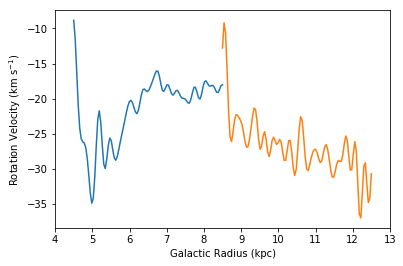

In [17]:
sun_rad = 8.5

X_grid = np.linspace(0, 4.0, 100)

# Looking inward toward the Galaxy
clf = Lasso(fit_intercept=True, **kwargs[i])
clf.fit(X_center, V_center)
fit_center = clf.predict(gaussian_basis(X_grid[:, None], centers, widths))    

plt.plot(sun_rad-X_grid, fit_center)



clf = Lasso(fit_intercept=True, **kwargs[i])
clf.fit(X_anticenter, V_anticenter)
fit_anticenter = clf.predict(gaussian_basis(X_grid[:, None], centers, widths))    

plt.plot(sun_rad+X_grid, fit_anticenter)


plt.xlabel('Galactic Radius (kpc)')
plt.ylabel(r'Rotation Velocity (km s$^{-1}$)')

plt.xlim(4, 13)

plt.show()